In [23]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define constants
INPUT_FILE = "/fast/nchandak/qaevals/lm-similarity/judge_w_gt_mmlu_pro_free_filtered/Qwen__Qwen2.5-7B-Instruct/samples.json"
OUTPUT_DIR = "/fast/nchandak/qaevals/lm-similarity/openrouter_judgments/mmlu_pro/Qwen__Qwen2.5-7B-Instruct"
OUTPUT_FILENAME = "openrouter_model_evals.json"

# Load the data
output_path = "/fast/nchandak/qaevals/judge_outputs/math_free/Qwen3-4B_thinking/samples.jsonl"
existing_items_map = {}

model_acc = {}

if os.path.exists(output_path):
    data = []
    with open(output_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    print(f"Loaded {len(data)} samples from {output_path}")
    print(json.dumps(data[0], indent=2))  # Print the first sample
    
    original_data = data
    # Filter data to keep only entries where response_deepseek-chat-v3-0324 exists and has length > 0
    filtered_data = []
    for item in original_data:
        response_field = "response_deepseek-chat-v3-0324"
        score_field = "score_deepseek-chat-v3-0324"
        
        if "mcq" in output_path:
            score_field = "exact_match"
            model_name = item["model"]
            if model_name in model_acc :
                model_acc[model_name].append(int(item[score_field]))
            else :
                model_acc[model_name] = [int(item[score_field])]
            
        if response_field in item and item[response_field] and len(item[response_field]) > 0:
            new_item = {}
            for key, value in item.items():
                if "14b" in key and "2.5" in key:
                    print(f"Dropping key: {key}")
                else :
                    new_item[key] = value
            filtered_data.append(new_item)
            existing_items_map[item["question_id"]] = new_item
    
    
    # drop keys from the item with "14b" in it 
    
    print(f"Filtered to {len(filtered_data)} samples with non-empty deepseek-chat-v3-0324 responses")
    data = filtered_data
    
    if "mcq" in output_path:
        # Calculate average accuracy for each model
        model_avg_acc = {}
        for model_name, scores in model_acc.items():
            model_avg_acc[model_name] = sum(scores) / len(scores)
        
        print("\nModel Average Accuracies:")
        for model_name, avg_acc in model_avg_acc.items():
            print(f"{model_name}: {avg_acc:.4f} (from {len(model_acc[model_name])} samples)")
        
        # Optionally, visualize the model accuracies
        plt.figure(figsize=(12, 8))
        models = list(model_avg_acc.keys())
        accuracies = [model_avg_acc[model] for model in models]
        
        # Sort by accuracy for better visualization
        sorted_indices = sorted(range(len(accuracies)), key=lambda i: accuracies[i], reverse=True)
        sorted_models = [models[i] for i in sorted_indices]
        sorted_accuracies = [accuracies[i] for i in sorted_indices]
        
        # Create bar plot with accuracy values displayed
        ax = sns.barplot(x=sorted_accuracies, y=sorted_models)
        
        # Add text with accuracy values at the end of each bar
        for i, acc in enumerate(sorted_accuracies):
            ax.text(acc, i, f' {acc*100:.2f}', va='center')
        
        plt.xlabel('Accuracy')
        plt.ylabel('Model')
        plt.title('Model Accuracies (on 200 datapoints)')
        plt.tight_layout()
        plt.show()
    
    # Save the filtered data if needed
    # with open(output_path, 'w') as f:
    #     json.dump(filtered_data, f, indent=2)


Loaded 1324 samples from /fast/nchandak/qaevals/judge_outputs/math_free/Qwen3-4B_thinking/samples.jsonl
{
  "question_id": 641,
  "question": "Evaluate $i^5+i^{-25}+i^{45}$.",
  "target": "i",
  "category": "Algebra",
  "filtered_resps": "i",
  "resps": " = i. So same result.\n\nTherefore, I think the answer is i. Therefore, the value of the expression is i. So I think that's correct.\n\n**Final Answer**\n\\boxed{i}\n</think>\n\nTo evaluate the expression:\n\n$$\ni^5 + i^{-25} + i^{45}\n$$\n\nwe begin by recalling the **cyclical nature of powers of the imaginary unit $ i $**:\n\n$$\ni^1 = i,\\quad i^2 = -1,\\quad i^3 = -i,\\quad i^4 = 1\n$$\n\nThis pattern repeats every 4 powers, so:\n\n$$\ni^n = i^{n \\mod 4}\n$$\n\n---\n\n### Step 1: Evaluate $ i^5 $\n\n$$\n5 \\mod 4 = 1 \\Rightarrow i^5 = i^1 = i\n$$\n\n---\n\n### Step 2: Evaluate $ i^{-25} $\n\nTo handle negative exponents, we can rewrite:\n\n$$\ni^{-25} = \\frac{1}{i^{25}}\n$$\n\nBut it's more efficient to reduce the exponent modu

In [26]:
# Load the samples file with model accuracy
model_name = os.path.basename(OUTPUT_DIR)  # Extract model name from OUTPUT_DIR
# Get the first file in the directory that matches the pattern
# import glob
# samples_dir = f"/fast/nchandak/qaevals/openllmleaderboard/{model_name}/"
# samples_files = glob.glob(f"{samples_dir}samples_leaderboard_mmlu_pro_*.jsonl")
samples_file = "/fast/nchandak/qaevals/judge_outputs/math_mcq/qwen2.5-3b-it_non_thinking/samples.jsonl"
samples_file = "/fast/nchandak/qaevals/judge_outputs/math_mcq/Qwen3-4B_thinking/samples.jsonl"
# Create a dictionary to map question_ids to their accuracy scores
question_id_to_acc = {}

# Read the JSONL file
overall_acc = 0
cnt = 0
with open(samples_file, 'r') as f:
    for line in f:
        if line.strip():  # Skip empty lines
            try:
                sample = json.loads(line)
                # Extract question_id and accuracy
                question_id = sample.get("question_id")
                acc = sample.get("exact_match")
                overall_acc += acc
                cnt += 1
                if question_id is not None and acc is not None:
                    question_id_to_acc[question_id] = float(acc)
                else:
                    print(f"Question ID {question_id} has no accuracy")
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON line: {e}")

print(f"Loaded {len(question_id_to_acc)} question_id to accuracy mappings")
print(f"Overall accuracy: {overall_acc/cnt*100:.2f}%")
# Add 'score_mcq' field to data based on question_id
for item in data:
    question_id = item.get("question_id")
    if question_id in question_id_to_acc:
        # Convert accuracy (which is likely 0 or 1) to string to match other score fields
        item["score_mcq"] = str(int(question_id_to_acc[question_id]))
    else:
        # If question_id not found, don't add the field
        print(f"Question ID {question_id} not found in question_id_to_acc")
        pass

# convert data to json for easy viewing
# with open("data.json", "w") as f:
#     json.dump(data, f, indent=2)

# Count how many items have the score_mcq field
count_with_mcq_score = sum(1 for item in data if "score_mcq" in item)
print(f"Added 'score_mcq' field to {count_with_mcq_score} out of {len(data)} items")

# Calculate MCQ accuracy
mcq_correct = sum(1 for item in data if "score_mcq" in item and item["score_mcq"] == "1")
mcq_accuracy = (mcq_correct / count_with_mcq_score * 100) if count_with_mcq_score > 0 else 0
print(f"MCQ accuracy: {mcq_correct}/{count_with_mcq_score} ({mcq_accuracy:.2f}%)")


Loaded 1288 question_id to accuracy mappings
Overall accuracy: 96.04%
Question ID 3481 not found in question_id_to_acc
Question ID 1306 not found in question_id_to_acc
Question ID 1734 not found in question_id_to_acc
Question ID 2631 not found in question_id_to_acc
Question ID 3123 not found in question_id_to_acc
Question ID 3091 not found in question_id_to_acc
Question ID 4794 not found in question_id_to_acc
Question ID 3281 not found in question_id_to_acc
Question ID 1278 not found in question_id_to_acc
Question ID 313 not found in question_id_to_acc
Question ID 2843 not found in question_id_to_acc
Question ID 2806 not found in question_id_to_acc
Question ID 613 not found in question_id_to_acc
Question ID 1632 not found in question_id_to_acc
Question ID 836 not found in question_id_to_acc
Question ID 4812 not found in question_id_to_acc
Question ID 2651 not found in question_id_to_acc
Question ID 1126 not found in question_id_to_acc
Question ID 3730 not found in question_id_to_acc
Qu

Agreements: {'deepseek-chat-v3-0324': 99.56521739130434, 'mcq': 98.04964539007092}
Accuracies: {'exact_match': 86.85800604229608, 'deepseek-chat-v3-0324': 87.08459214501511, 'mcq': 96.04037267080744}

Accuracy by judge:
mcq: 96.04%
deepseek-chat-v3-0324: 87.08%
exact_match: 86.86%


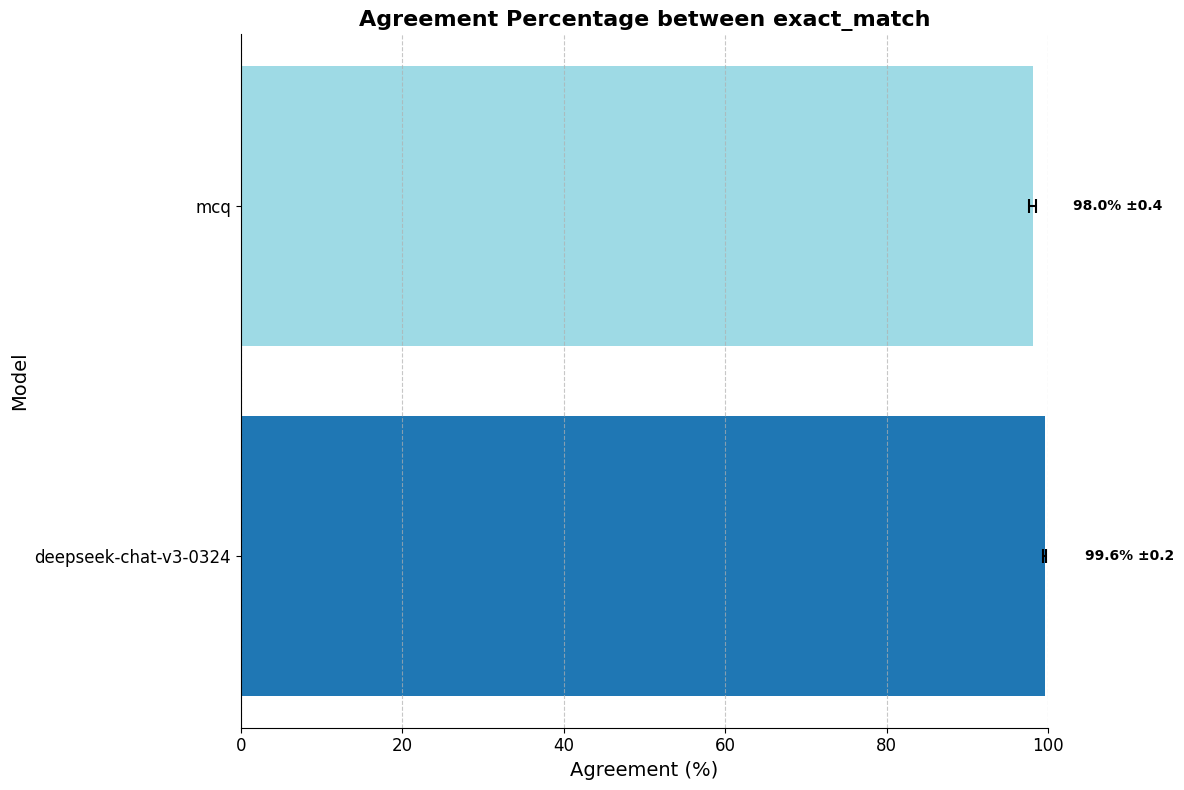

Agreement percentages with exact_match:
deepseek-chat-v3-0324: 99.57% ±0.20%
mcq: 98.05% ±0.42%


In [27]:
import numpy as np
# Calculate agreement between deepseek and other judges
def calculate_agreement(data):
    """Calculate agreement percentage between exact_match and other judges."""
    reference_field = "exact_match"
    
    # Find all score fields
    score_fields = [field for field in data[0].keys() if field.startswith("score_")]
    
    # Calculate agreement percentages and accuracy for each model
    agreements = {}
    accuracies = {}
    agreement_counts = {}  # Store counts for error calculation
    
    # Calculate accuracy for reference model
    ref_correct = sum(1 for item in data if reference_field in item and item[reference_field] == 1)
    ref_total = sum(1 for item in data if reference_field in item)
    if ref_total > 0:
        accuracies["exact_match"] = (ref_correct / ref_total) * 100
    
    for field in score_fields:
        if field == reference_field:
            continue
            
        model_name = field.replace("score_", "")
        agreement_count = 0
        valid_count = 0
        
        # Calculate accuracy for this model
        correct_count = sum(1 for item in data if field in item and item[field] == "1")
        total_count = sum(1 for item in data if field in item)
        if total_count > 0:
            accuracies[model_name] = (correct_count / total_count) * 100
        
        for item in data:
            # Only count if both scores exist
            if reference_field in item and field in item and item[reference_field] and item[field]:
                valid_count += 1
                if int(item[reference_field]) == int(item[field]):
                    agreement_count += 1
        
        if valid_count > 0:
            agreements[model_name] = (agreement_count / valid_count) * 100
            agreement_counts[model_name] = (agreement_count, valid_count)  # Store for error calculation
    
    print(f"Agreements: {agreements}")
    print(f"Accuracies: {accuracies}")
    
    # Print accuracy for each judge
    print("\nAccuracy by judge:")
    for model, accuracy in sorted(accuracies.items(), key=lambda x: x[1], reverse=True):
        print(f"{model}: {accuracy:.2f}%")
    
    return agreements, agreement_counts
# Calculate agreement percentages and counts
agreement_percentages, agreement_counts = calculate_agreement(data)

# Calculate standard errors using bootstrapping
np.random.seed(42)  # For reproducibility
n_bootstrap = 10000
std_errors = {}

for model, (agree_count, total_count) in agreement_counts.items():
    # Create binary array representing agreements (1) and disagreements (0)
    binary_data = np.concatenate([
        np.ones(agree_count),
        np.zeros(total_count - agree_count)
    ])
    
    # Bootstrap resampling
    bootstrap_estimates = []
    for _ in range(n_bootstrap):
        bootstrap_sample = np.random.choice(binary_data, size=total_count, replace=True)
        bootstrap_agreement = 100 * np.mean(bootstrap_sample)  # Convert to percentage
        bootstrap_estimates.append(bootstrap_agreement)
    
    # Calculate standard error from bootstrap distribution
    std_error = np.std(bootstrap_estimates)
    std_errors[model] = std_error
    # print(f"{model}: {agree_count}/{total_count} = {std_error:.2f}%")

# Convert to DataFrame for easier plotting
agreement_df = pd.DataFrame({
    'Model': list(agreement_percentages.keys()),
    'Agreement (%)': list(agreement_percentages.values()),
    'Std_Error': [std_errors[model] for model in agreement_percentages.keys()]
})

# Sort by agreement percentage for better visualization
agreement_df = agreement_df.sort_values('Agreement (%)', ascending=False)

# Create the bar plot using matplotlib
fig, ax = plt.subplots(figsize=(12, 8))
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Define a colorful palette
colors = plt.cm.tab20(np.linspace(0, 1, len(agreement_df)))

# Plot bars
bars = ax.barh(agreement_df['Model'], agreement_df['Agreement (%)'], color=colors)

# Add error bars
for i, (_, row) in enumerate(agreement_df.iterrows()):
    ax.errorbar(row['Agreement (%)'], i, xerr=row['Std_Error'], 
                color='black', capsize=5, elinewidth=1.5, markeredgewidth=1.5)

# Add percentage labels to the bars
for i, bar in enumerate(bars):
    value = agreement_df['Agreement (%)'].iloc[i]
    error = agreement_df['Std_Error'].iloc[i]
    ax.text(value + 5.0, bar.get_y() + bar.get_height()/2, 
            f"{value:.1f}% ±{error:.1f}", va='center', fontweight='bold')

# Set title and labels
ax.set_title('Agreement Percentage between exact_match', fontsize=16, fontweight='bold')
ax.set_xlabel('Agreement (%)', fontsize=14)
ax.set_ylabel('Model', fontsize=14)
ax.set_xlim(0, 100)  # Set x-axis limits from 0 to 100%

# Customize appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

# Show the plot
plt.show()

# Print the agreement percentages
print("Agreement percentages with exact_match:")
for model, agreement in sorted(agreement_percentages.items(), key=lambda x: x[1], reverse=True):
    std_error = std_errors[model]
    print(f"{model}: {agreement:.2f}% ±{std_error:.2f}%")


### Human alignment plot



=== Analysis for human_1 ===

Agreements: {'deepseek-chat-v3-0324': 86.06060606060606, 'qwen-2.5-7b-instruct': 84.84848484848484, 'qwen-2.5-72b-instruct': 87.27272727272727, 'llama-4-scout': 87.27272727272727, 'llama-4-maverick': 84.84848484848484, 'qwen3-8b': 83.03030303030303, 'qwen3-14b': 84.54545454545455, 'llama-3.1-8b-instruct': 80.0, 'llama-3-8b-instruct': 76.96969696969697, 'human_2': 90.09287925696594, 'mcq': 74.24242424242425}
Accuracies: {'human_1': 63.030303030303024, 'deepseek-chat-v3-0324': 60.97804391217565, 'qwen-2.5-7b-instruct': 61.97604790419161, 'qwen-2.5-72b-instruct': 62.974051896207584, 'llama-4-scout': 65.6686626746507, 'llama-4-maverick': 71.35728542914171, 'qwen3-8b': 53.99201596806387, 'qwen3-14b': 59.2814371257485, 'llama-3.1-8b-instruct': 74.45109780439122, 'llama-3-8b-instruct': 78.94211576846307, 'human_2': 62.70783847980997, 'mcq': 84.63073852295409}
Standard Errors: {'deepseek-chat-v3-0324': 1.940104036667772, 'qwen-2.5-7b-instruct': 1.966733785099262

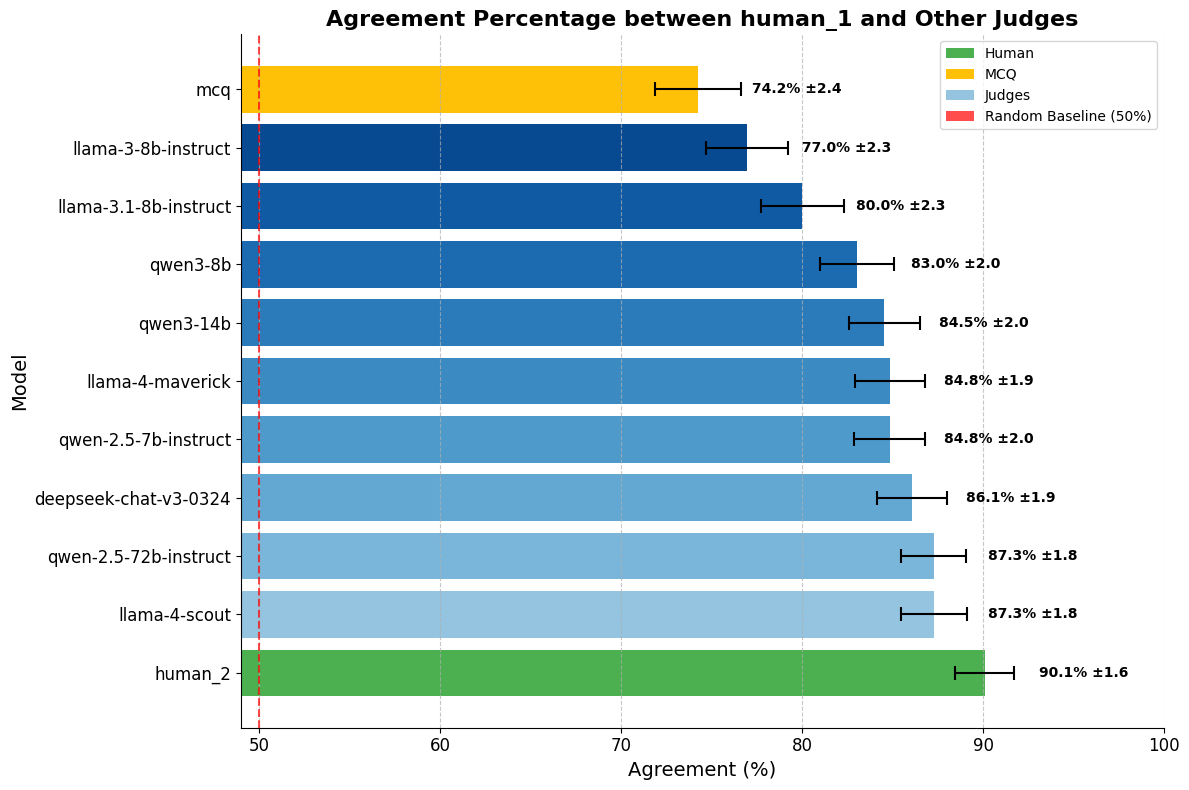

Agreement percentages with human_1:
(Note: Random baseline agreement would be 50%)
human_2: 90.09% ±1.63%
qwen-2.5-72b-instruct: 87.27% ±1.80%
llama-4-scout: 87.27% ±1.82%
deepseek-chat-v3-0324: 86.06% ±1.94%
qwen-2.5-7b-instruct: 84.85% ±1.97%
llama-4-maverick: 84.85% ±1.95%
qwen3-14b: 84.55% ±1.96%
qwen3-8b: 83.03% ±2.04%
llama-3.1-8b-instruct: 80.00% ±2.29%
llama-3-8b-instruct: 76.97% ±2.27%
mcq: 74.24% ±2.36%


=== Analysis for human_2 ===

Agreements: {'deepseek-chat-v3-0324': 88.83610451306413, 'qwen-2.5-7b-instruct': 84.56057007125891, 'qwen-2.5-72b-instruct': 88.36104513064133, 'llama-4-scout': 88.59857482185272, 'llama-4-maverick': 85.74821852731591, 'qwen3-8b': 85.2731591448931, 'qwen3-14b': 88.12351543942994, 'llama-3.1-8b-instruct': 81.23515439429929, 'llama-3-8b-instruct': 76.95961995249407, 'human_1': 90.09287925696594, 'mcq': 74.58432304038006}
Accuracies: {'human_2': 62.70783847980997, 'deepseek-chat-v3-0324': 60.97804391217565, 'qwen-2.5-7b-instruct': 61.97604790419161

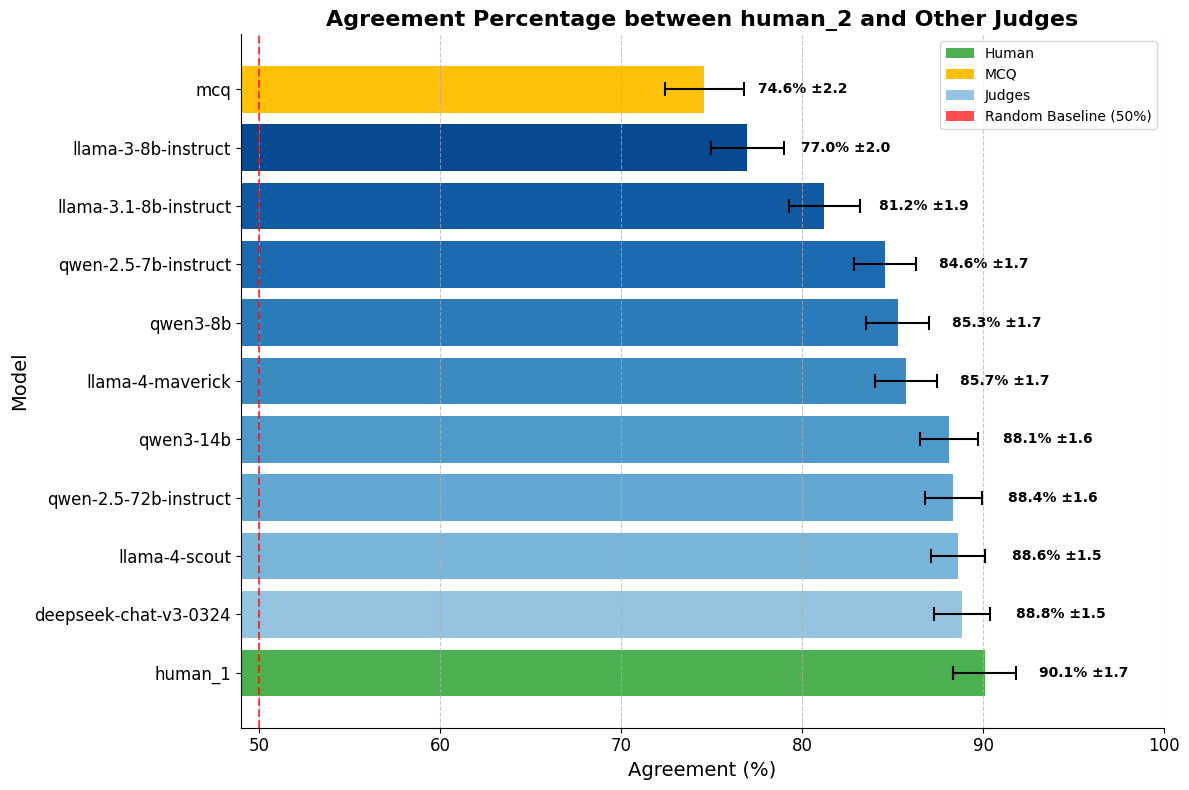

Agreement percentages with human_2:
(Note: Random baseline agreement would be 50%)
human_1: 90.09% ±1.74%
deepseek-chat-v3-0324: 88.84% ±1.53%
llama-4-scout: 88.60% ±1.48%
qwen-2.5-72b-instruct: 88.36% ±1.59%
qwen3-14b: 88.12% ±1.60%
llama-4-maverick: 85.75% ±1.72%
qwen3-8b: 85.27% ±1.74%
qwen-2.5-7b-instruct: 84.56% ±1.71%
llama-3.1-8b-instruct: 81.24% ±1.95%
llama-3-8b-instruct: 76.96% ±2.02%
mcq: 74.58% ±2.18%


In [46]:
# Calculate agreement between reference model and other judges
def calculate_agreement(data, reference_model):
    """Calculate agreement percentage between reference model and other judges."""
    reference_field = f"score_{reference_model}"
    
    # Find all score fields
    score_fields = [field for field in data[0].keys() if field.startswith("score_")]
    
    # Calculate agreement percentages and accuracy for each model
    agreements = {}
    accuracies = {}
    std_errors = {}
    
    # Calculate accuracy for reference model
    ref_correct = sum(1 for item in data if reference_field in item and item[reference_field] == "1")
    ref_total = sum(1 for item in data if reference_field in item)
    if ref_total > 0:
        accuracies[reference_model] = (ref_correct / ref_total) * 100
    
    for field in score_fields:
        if field == reference_field:
            continue
            
        model_name = field.replace("score_", "")
        agreement_count = 0
        valid_count = 0
        
        # Calculate accuracy for this model
        correct_count = sum(1 for item in data if field in item and item[field] == "1")
        total_count = sum(1 for item in data if field in item)
        if total_count > 0:
            accuracies[model_name] = (correct_count / total_count) * 100
        
        # Collect agreement data for bootstrapping
        agreement_data = []
        for item in data:
            # Only count if both scores exist
            if reference_field in item and field in item and item[reference_field] and item[field]:
                valid_count += 1
                is_agreement = item[reference_field] == item[field]
                agreement_data.append(is_agreement)
                if is_agreement:
                    agreement_count += 1
        
        if valid_count > 0:
            agreements[model_name] = (agreement_count / valid_count) * 100
            
            # Bootstrap to calculate standard error
            n_bootstrap = 1000
            bootstrap_agreements = []
            for _ in range(n_bootstrap):
                # Sample with replacement
                bootstrap_sample = np.random.choice(agreement_data, size=len(agreement_data), replace=True)
                bootstrap_agreement = (np.sum(bootstrap_sample) / len(bootstrap_sample)) * 100
                bootstrap_agreements.append(bootstrap_agreement)
            
            # Calculate standard error from bootstrap samples
            std_errors[model_name] = np.std(bootstrap_agreements)
    
    print(f"Agreements: {agreements}")
    print(f"Accuracies: {accuracies}")
    print(f"Standard Errors: {std_errors}")
    
    # Print accuracy for each judge
    print("\nAccuracy by judge:")
    for model, accuracy in sorted(accuracies.items(), key=lambda x: x[1], reverse=True):
        print(f"{model}: {accuracy:.2f}%")
    
    return agreements, std_errors

# Iterate through human annotators
for i in range(1, 3):
    human_annotator = f"human_{i}"
    print(f"\n\n=== Analysis for {human_annotator} ===\n")
    
    # Calculate agreement percentages and standard errors
    agreement_percentages, std_errors = calculate_agreement(data, reference_model=human_annotator)

    # Convert to DataFrame for easier plotting
    agreement_df = pd.DataFrame({
        'Model': list(agreement_percentages.keys()),
        'Agreement (%)': list(agreement_percentages.values()),
        'Std_Error': [std_errors[model] for model in agreement_percentages.keys()],
        'Type': ['Human' if 'human' in model else 'MCQ' if 'mcq' in model else 'Judge' for model in agreement_percentages.keys()]
    })

    # Sort by agreement percentage for better visualization
    agreement_df = agreement_df.sort_values('Agreement (%)', ascending=False)

    # Create the bar plot with matplotlib
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define distinct colors for different types
    human_color = '#4CAF50'  # Green
    mcq_color = '#FFC107'    # Yellow
    
    # Create a gradient for judges
    judge_indices = [i for i, t in enumerate(agreement_df['Type']) if t == 'Judge']
    judge_colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(judge_indices)))
    
    # Assign colors based on type
    colors = []
    judge_idx = 0
    for model_type in agreement_df['Type']:
        if model_type == 'Human':
            colors.append(human_color)
        elif model_type == 'MCQ':
            colors.append(mcq_color)
        else:  # Judge
            colors.append(judge_colors[judge_idx])
            judge_idx += 1
    
    # Plot horizontal bars
    bars = ax.barh(agreement_df['Model'], agreement_df['Agreement (%)'], color=colors)
    
    # Add error bars
    for i, (_, row) in enumerate(agreement_df.iterrows()):
        ax.errorbar(row['Agreement (%)'], i, xerr=row['Std_Error'], 
                    color='black', capsize=5, elinewidth=1.5, markeredgewidth=1.5)
    
    # Add percentage labels to the bars
    for i, bar in enumerate(bars):
        value = agreement_df['Agreement (%)'].iloc[i]
        error = agreement_df['Std_Error'].iloc[i]
        ax.text(value + 3.0, bar.get_y() + bar.get_height()/2, 
                f"{value:.1f}% ±{error:.1f}", va='center', fontweight='bold')
    
    # Set title and labels
    ax.set_title(f'Agreement Percentage between {human_annotator} and Other Judges', 
                fontsize=16, fontweight='bold')
    ax.set_xlabel('Agreement (%)', fontsize=14)
    ax.set_ylabel('Model', fontsize=14)
    ax.set_xlim(49, 100)  # Set x-axis limits from 50% to 100%
    
    # Customize appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add a legend for the color scheme
    from matplotlib.patches import Patch
    
    # Add a baseline reference line at 50% (random agreement)
    ax.axvline(x=50, color='red', linestyle='--', alpha=0.7)
    # ax.text(51, 0.5, 'Random Baseline (50%)', va='center', color='red', fontweight='bold', rotation=90)
    
    # Update the legend to include the baseline
    legend_elements = [
        Patch(facecolor=human_color, label='Human'),
        Patch(facecolor=mcq_color, label='MCQ'),
        Patch(facecolor=judge_colors[0], label='Judges'),
        Patch(facecolor='red', alpha=0.7, label='Random Baseline (50%)')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    plt.tight_layout()
    
    # Show the plot
    plt.show()

    # Print the agreement percentages
    print(f"Agreement percentages with {human_annotator}:")
    print(f"(Note: Random baseline agreement would be 50%)")
    for model, agreement in sorted(agreement_percentages.items(), key=lambda x: x[1], reverse=True):
        std_error = std_errors[model]
        print(f"{model}: {agreement:.2f}% ±{std_error:.2f}%")
